In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [5]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

In [19]:
kospi200 = pd.read_csv("./data/data.csv", encoding="cp949")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)
kospi200.head()

,종목코드,종목명
0,006840,AK홀딩스
1,027410,BGF
2,282330,BGF리테일
3,138930,BNK금융지주
4,001040,CJ


In [20]:
code_dict = {i:j for i,j in zip(kospi200["종목명"], kospi200["종목코드"])}

In [8]:
import pickle

with open('raw_data_20180811.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [9]:
raw_data.keys()

dict_keys(['006840', '027410', '282330', '138930', '001040', '079160', '000120', '097950', '005830', '000990', '114090', '078930', '006360', '007070', '012630', '294870', '001060', '096760', '105560', '002380', '030200', '033780', '093050', '003550', '034220', '001120', '051900', '032640', '011070', '066570', '108670', '051910', '079550', '006260', '010120', '035420', '005940', '010060', '005490', '064960', '010950', '034120', '034730', '011790', '001740', '006120', '096770', '285130', '017670', '000660', '005610', '035250', '010130', '002240', '011780', '073240', '000270', '024110', '003920', '025860', '002350', '251270', '006280', '005250', '004370', '019680', '008060', '000210', '001680', '047040', '042660', '069620', '006650', '003490', '001230', '026960', '000640', '170900', '001520', '049770', '014820', '000150', '241560', '042670', '034020', '115390', '023530', '004000', '004990', '005300', '011170', '002270', '071840', '204320', '008560', '033920', '006800', '003850', '003000',

In [22]:
key = code_dict["후성"]
raw_data[key].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,8040.0,8060.0,7840.0,7930.0,7930.0,924009
2012-01-03,8030.0,8130.0,7960.0,8130.0,8130.0,1446769
2012-01-04,8180.0,8190.0,7740.0,7790.0,7790.0,2572811
2012-01-05,7770.0,8040.0,7530.0,7810.0,7810.0,2709421
2012-01-06,7990.0,7990.0,7660.0,7740.0,7740.0,1344327


In [72]:
def get_macd(df, short=12, long=26, t=9): 
    
    # 입력받은 값이 dataframe이라는 것을 정의해줌 
    df = pd.DataFrame(df) 
    
    # MACD 관련 수식 
    ma_12 = df.Close.ewm(span=12).mean() # 단기(12) EMA(지수이동평균) 
    ma_26 = df.Close.ewm(span=26).mean() # 장기(26) EMA 
    macd = ma_12 - ma_26 # MACD 
    macds = macd.ewm(span=9).mean() # Signal 
    macdo = macd - macds # Oscillator 
    
    df = df.assign(macd=macd, signal=macds, oscilator=macdo).dropna() 
    return df

# 출처: http://excelsior-cjh.tistory.com/110?category=975542 [EXCELSIOR]

In [26]:
raw_data["005930"].Close.ewm(span=12)

EWM [com=5.5,min_periods=0,adjust=True,ignore_na=False,axis=0]

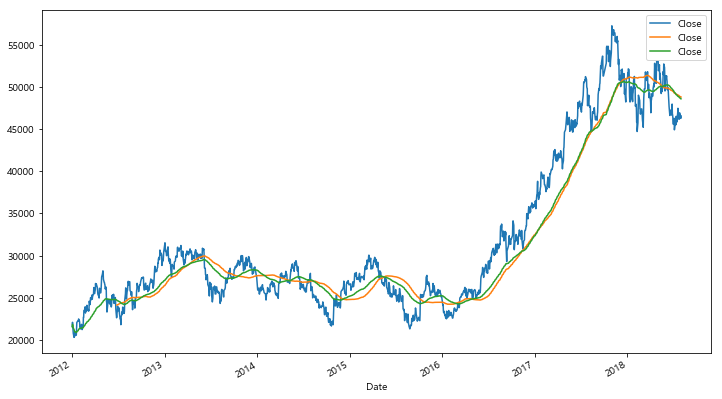

In [63]:
pd.concat((raw_data["005930"].Close,raw_data["005930"].Close.rolling(120).mean(),raw_data["005930"].Close.ewm(span=120).mean()), axis=1).plot(figsize=(12,7))

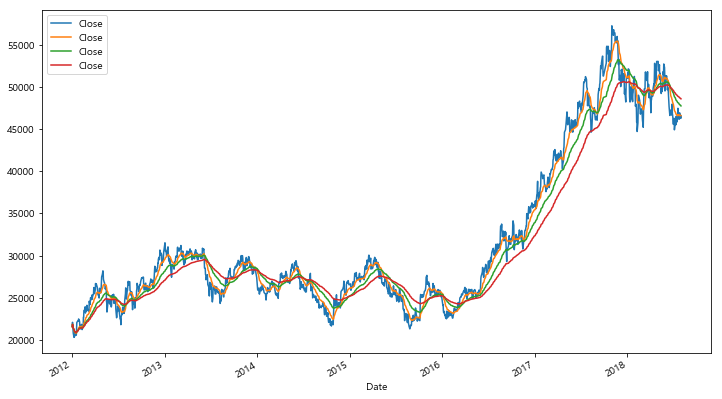

In [65]:
pd.concat((raw_data["005930"].Close, raw_data["005930"].Close.ewm(span=20).mean(),raw_data["005930"].Close.ewm(span=60).mean(), raw_data["005930"].Close.ewm(span=120).mean()), axis=1).plot(figsize=(12,7))

In [87]:
a = ((raw_data["005930"].Close.ewm(span=12).mean() - raw_data["005930"].Close.ewm(span=26).mean()) > 0).replace({False:None,True:20000})

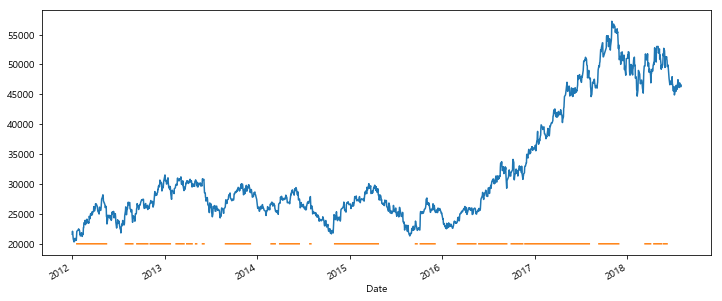

In [88]:
#plt.subplot(211)
raw_data["005930"].Close.plot(figsize=(12,10))
#plt.subplot(212)
a.plot(figsize=(12,5))

In [70]:
len(raw_data)

202

In [172]:
for i in raw_data.keys():
    raw_data[i] = get_macd(raw_data[i])
    raw_data[i] = raw_data[i].assign(cond1 = raw_data[i]["macd"] > 0, cond2 = raw_data[i]["oscilator"] > 0)
    raw_data[i] = raw_data[i].assign(long_short = raw_data[i]["cond1"] & raw_data[i]["cond2"])
    raw_data[i].long_short = raw_data[i].long_short.replace({False:0,True:1})
    raw_data[i] = raw_data[i].assign(pct_change = raw_data[i].Close.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(Y = np.where(raw_data[i]["pct_change"].fillna(0)>=0, 1,0))

SyntaxError: keyword can't be an expression (<ipython-input-172-ec93b818a9ae>, line 4)

In [173]:
for i in raw_data.keys():
    for j in [10,15,20,25,40,60,100,120]:
        raw_data[i] = raw_data[i].assign(ma_10 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_15 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_20 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_25 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_40 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_60 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_100 = raw_data[i].Close.ewm(span = j).mean())
        raw_data[i] = raw_data[i].assign(ma_120 = raw_data[i].Close.ewm(span = j).mean())

In [152]:
raw_data["005930"].Close.head()

Date
2012-01-02    21600.0
2012-01-03    22100.0
2012-01-04    21600.0
2012-01-05    21100.0
2012-01-06    20800.0
Name: Close, dtype: float64

In [150]:
raw_data["005930"].Close.pct_change().head()

Date
2012-01-02         NaN
2012-01-03    0.023148
2012-01-04   -0.022624
2012-01-05   -0.023148
2012-01-06   -0.014218
Name: Close, dtype: float64

In [166]:
np.where(raw_data["005930"]["pct_change"].fillna(0)>=0, 1,0)

array([1, 0, 0, ..., 0, 0, 1])

In [174]:
raw_data["005930"].iloc[:np.int(len(raw_data["005930"])*0.8)].tail()

,Open,High,Low,Close,Adj Close,Volume,macd,signal,oscilator,cond1,...,pct_change,Y,ma_10,ma_15,ma_20,ma_25,ma_40,ma_60,ma_100,ma_120
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-24,41600.0,41980.0,41080.0,41500.0,8919.792969,12808150,927.329088,888.299115,39.029973,True,...,-0.007177,0,36621.837607,36621.837607,36621.837607,36621.837607,36621.837607,36621.837607,36621.837607,36621.837607
2017-03-27,41200.0,41880.0,41180.0,41200.0,8855.311523,12177650,838.474475,878.334187,-39.859712,True,...,-0.007229,0,36697.509713,36697.509713,36697.509713,36697.509713,36697.509713,36697.509713,36697.509713,36697.509713
2017-03-28,41560.0,41840.0,41380.0,41480.0,8915.493164,8216250,781.639955,858.995341,-77.355386,True,...,0.006796,1,36776.559139,36776.559139,36776.559139,36776.559139,36776.559139,36776.559139,36776.559139,36776.559139
2017-03-29,41740.0,41960.0,41580.0,41780.0,8979.974609,10093250,752.135530,837.623379,-85.487848,True,...,0.007232,1,36859.260641,36859.260641,36859.260641,36859.260641,36859.260641,36859.260641,36859.260641,36859.260641
2017-03-30,41880.0,42440.0,41880.0,41980.0,10838.968750,8204000,736.402599,817.379223,-80.976623,True,...,0.004787,1,36943.900961,36943.900961,36943.900961,36943.900961,36943.900961,36943.900961,36943.900961,36943.900961


In [175]:
raw_data["005930"].iloc[np.int(len(raw_data["005930"])*0.8):].head()

,Open,High,Low,Close,Adj Close,Volume,macd,signal,oscilator,cond1,...,pct_change,Y,ma_10,ma_15,ma_20,ma_25,ma_40,ma_60,ma_100,ma_120
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-31,41820.0,42020.0,41200.0,41200.0,10637.577148,10500300,653.461954,784.595769,-131.133815,True,...,-0.018580,0,37014.249705,37014.249705,37014.249705,37014.249705,37014.249705,37014.249705,37014.249705,37014.249705
2017-04-03,41400.0,41720.0,41300.0,41440.0,10699.542969,9579400,600.178407,747.712297,-147.533890,True,...,0.005825,1,37087.402603,37087.402603,37087.402603,37087.402603,37087.402603,37087.402603,37087.402603,37087.402603
2017-04-04,41600.0,42180.0,41520.0,42080.0,10864.787109,12255500,602.646529,718.699143,-116.052614,True,...,0.015444,1,37169.924874,37169.924874,37169.924874,37169.924874,37169.924874,37169.924874,37169.924874,37169.924874
2017-04-05,41900.0,42240.0,41700.0,42140.0,10880.279297,10699700,602.498800,695.459074,-92.960274,True,...,0.001426,1,37252.074876,37252.074876,37252.074876,37252.074876,37252.074876,37252.074876,37252.074876,37252.074876
2017-04-06,42000.0,42080.0,41600.0,41840.0,10802.820313,9683400,571.585352,670.684330,-99.098978,True,...,-0.007119,0,37327.908349,37327.908349,37327.908349,37327.908349,37327.908349,37327.908349,37327.908349,37327.908349


In [176]:
train = {}
train_idx = {}
test = {}
test_idx = {}
for code, df in raw_data.items():
    train[code] = df.iloc[:int(len(df)*0.8)][["ma_10", "Volume", "long_short"]]
    train_idx[code] = df.iloc[:int(len(df)*0.8)]["Y"]
    test[code] = df.iloc[int(len(df)*0.8):][["ma_10", "Volume", "long_short"]]
    test_idx[code] = df.iloc[int(len(df)*0.8):]["Y"]

In [182]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
li = ["ma_10", "Volume"]
for code in raw_data.keys():
    train[code][li] = std_scaler.fit_transform(train[code][li].values)
    test[code][li] = std_scaler.fit_transform(test[code][li].values)

In [186]:
train["005930"].values[:,1]

array([ 0.66314481,  0.69319604,  0.72644966, ..., -0.82472853,
       -0.50414789, -0.82682076])

In [188]:
train_idx["005930"].values

array([1, 0, 0, ..., 1, 1, 1])

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gnb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier(random_state=42)

params_rf = [
    {'n_estimators' : [i for i in range(50) if i % 2 == 1],
    'criterion' : ["gini", "entropy"],
    'oob_score' : ["True"],
    'n_jobs' : [2]},
    {'n_estimators' : [i for i in range(100) if i % 3 == 1],
    'criterion' : ["gini", "entropy"],
    'oob_score' : ["True"],
    'n_jobs' : [2]}
]
params_knn = [
    {'n_neighbors' : [i for i in range(100) if i % 3 == 1],
    'weights' : ["uniform", "distance"],
    'algorithm' : ["kd_tree", "ball_tree", "brute"],
    'p' : [i for i in range(11)]}
]
params_gnb = [
    {'alpha' : [i-5 for i in range(20)],
    'binarize' : [i-5 for i in range(20)]}
]

In [194]:
from sklearn.metrics import accuracy_score

score_list = pd.DataFrame(columns=('GNB','KNN','RF'))
up_stock = pd.DataFrame(columns=('GNB_up_ratio','KNN_up_ratio','RF_up_ratio'))

for i in raw_data.keys():
    a=[]
    b=[]
    X_train = train[i].values
    y_train = train_idx[i].values
    X_test = test[i].values
    y_test = test_idx[i].values
    for clf in (gnb_clf, knn_clf, rf_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a.append(accuracy_score(y_test, y_pred))
        b.append(np.count_nonzero(y_pred==1)/len(y_pred))
    score_list.loc[i]=a
    up_stock.loc[i]=b

In [198]:
score_list

,GNB,KNN,RF
006840,0.552469,0.524691,0.552469
027410,0.560386,0.671498,0.613527
282330,0.406250,0.312500,0.593750
138930,0.487654,0.527778,0.487654
001040,0.500000,0.450617,0.469136
079160,0.527778,0.564815,0.530864
000120,0.561728,0.530864,0.521605
097950,0.503086,0.512346,0.546296
005830,0.438272,0.527778,0.493827
000990,0.561728,0.546296,0.518519
